# Задача классификации изображений

Необходимо решить задачу классификации по распознаванию четырех видов блюд - Bread, Dessert, Meat, Soup. Первоначального разделения выборки на обучающую и тестовую части нет.

Для обучения классификатора изображений с помощью PyTorch нужно выполнить следующие действия:

1. Загрузка данных. 
2. Определение нейронной сети свертки.
3. Определение функции потери.
4. Обучение модели по данным для обучения.
5. Тестирование модели по данным для проверки.

In [1]:
import cv2
import numpy as np
import tqdm.notebook as tq

import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchsummary

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from model import ClassificationModel

from dataset import CustomDataset
from utils import calcAccuracy
from trainer import Trainer

## Формирование датасета
Подробную информацию по созданию и работе с датасетом см. в файле *dataset.py*

In [2]:
dataset = CustomDataset()

## Разбиение на тренировочную, тестовую и валидационную выборку<br/>с коэффициентом 0.2

Мы разбиваем выборку на тренировочную, тестовую и валидационную для того, чтобы проводить тестирование на том, что не связано с обучением.

In [3]:
dataset = CustomDataset()
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2)
dataset_train, dataset_val = train_test_split(dataset_train, test_size=0.2)

data_loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)

print('Train data length:', len(data_loader_train))
print('Test data length:', len(data_loader_test))
print('Validation data length:', len(data_loader_val))

Train data length: 260
Test data length: 82
Validation data length: 1037


## Вывод примеров тренировочных данных
Мы вывели четыре картинки, отвечающие за каждую категорию в датасете.

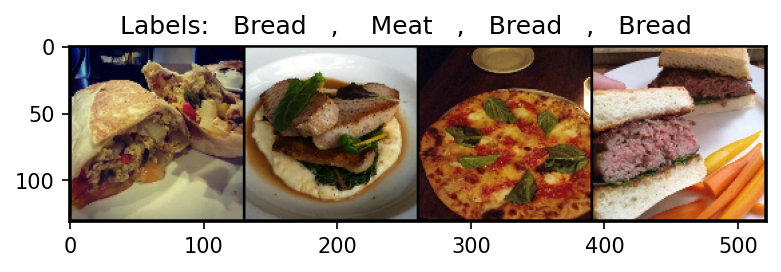

In [4]:
train_features, train_labels = next(iter(data_loader_train))
train_features = dataset.getImgsTensors(train_features)[:4]

plt.title('Labels:'.center(8) + ', '.join([dataset.getName(i).center(10) for i in train_labels[:4]]))
gridImgs = torchvision.utils.make_grid(train_features)
plt.imshow(cv2.cvtColor(gridImgs.permute(1, 2, 0).numpy() / 255, cv2.COLOR_BGR2RGB))
plt.show()

## Определение доступного устройства для обучения

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Used device:', device)

Used device: cuda


## Создание модели и вывод информации о ней

Класс нейронных сетей CNN определяется как многослойные нейронные сети, предназначенные для обнаружения сложных признаков в данных. Это наиболее применимый тип в приложениях компьютерного зрения.

Слой свертки является основным в структуре CNN и предназначен для обнаружения признаков на изображениях. Каждый из слоев содержит несколько каналов, которые обнаруживают определенные виды признаков, а также несколько ядер для определения размера обнаруженных признаков.

* Сверточные нейронные сети характеризуются наличием torch.nn.Conv2D, который отвечает за выделение черт или другими словами features данных. Формула, практически такая же как у линейного слоя wx+b, только между w и x взаимнокорреляционная функция.
* Слой __ReLU__ выполняет роль функции активации, которая присваивает всем входящим признакам значения не меньше нуля. При применении этого слоя все отрицательные числа заменяются нулями, а положительные сохраняются без изменений.
* Слои __Linear__ используются для вычисления оценки по каждому классу.


In [6]:
model = ClassificationModel().to(device)
# описание модели
torchsummary.summary(model, (3, 128, 128))

Model created!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 62, 62]           3,648
              ReLU-2           [-1, 48, 62, 62]               0
         MaxPool2d-3           [-1, 48, 30, 30]               0
            Conv2d-4          [-1, 128, 30, 30]         153,728
              ReLU-5          [-1, 128, 30, 30]               0
         MaxPool2d-6          [-1, 128, 14, 14]               0
            Conv2d-7          [-1, 256, 14, 14]         295,168
              ReLU-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         590,080
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]         295,040
             ReLU-12          [-1, 128, 14, 14]               0
        MaxPool2d-13            [-1, 128, 6, 6]               0
           Linear-14    

## Определение класса для обучения и проверки модели 

Функция потерь - **Cross Entropy** - Функция потерь определает насколько наши данные отличаются от того, что производит наша нейронная сеть. Когда мы хотим, чтобы модель научилась что-то делать, мы даем ей обратную связь о том, насколько хорошо она это делает. Эта функция, которая вычисляет объективную меру эффективности модели.


Оптимизатор - **SGD** - Реализует стохастический градиентный спуск:
- lerning rate = $10^{-3}$,
- momentum = 0.9;

In [7]:
trainer = Trainer(model, data_loader_train, data_loader_test, data_loader_val,
                  device, getTensorsFunc=dataset.getImgsTensors, tqdm=tq.tqdm)

## Обучение модели и подсчет ошибки для тестовой выборки

Основная задача нейронной сети заключается в минимизации функции потери путем корректировки значений векторных весовых коэффициентов через функцию обратного распространения. Значение потери (Loss) не совпадает с точностью модели (Accuracy). Функция потери дает приблизительное представление о том, насколько хорошо работает модель после каждой итерации процесса оптимизации по набору для обучения. В свою очередь, точность модели вычисляется по набору для проверки и обозначает долю правильных прогнозов по нему.

Чтобы обучить модель, нужно в цикле пропустить ее через итератор данных, передавая в сеть входные данные и оптимизируя ее результаты. Чтобы проверить результаты, просто сравните прогнозируемые метки с фактическими в наборе данных для проверки после каждой учебной эпохи.

Программа будет отображать потери при обучении, потери при проверке и точность модели для каждой эпохи или для каждой выполненной итерации по набору для обучения. При этом модель будет сохранена с максимальной точностью.

По результатам обучения на графиках выводятся потеря (Loss) и средняя точность (Accuracy) обучения.

<IPython.core.display.Javascript object>


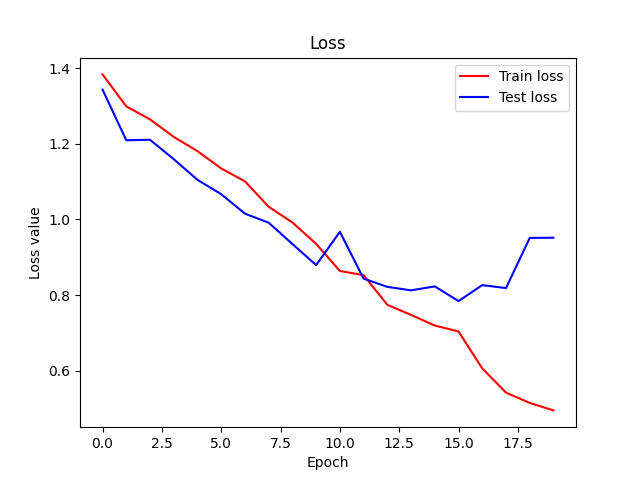

<IPython.core.display.Javascript object>


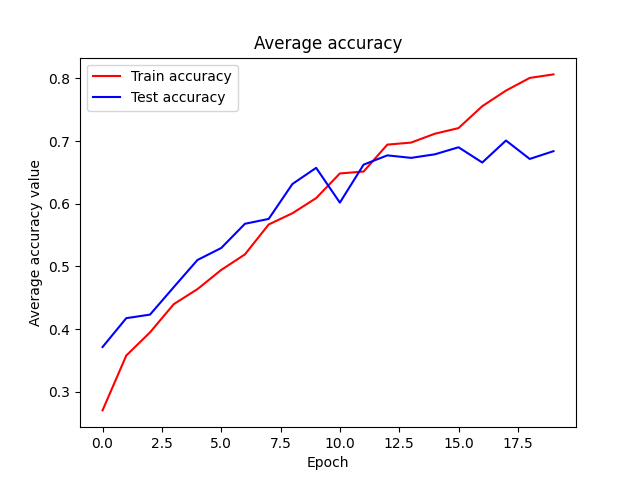

[1] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[1] Train loss: 359.6655181646 1.3833289160
[1] Train average accuracy: 0.27
[1] Train accuracy in classes:
	Bread: 0.38
	Dessert: 0.14
	Meat: 0.51
	Soup: 0.05


[1] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[1] Test loss: 110.1354781389 1.3431155871
[1] Test average accuracy: 0.37
[1] Test accuracy in classes:
	Bread: 0.91
	Dessert: 0.00
	Meat: 0.58
	Soup: 0.00
This is new best model
------------------------------


[2] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[2] Train loss: 337.6979477406 1.2988382605
[2] Train average accuracy: 0.36
[2] Train accuracy in classes:
	Bread: 0.47
	Dessert: 0.11
	Meat: 0.59
	Soup: 0.26


[2] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[2] Test loss: 99.1709750295 1.2094021345
[2] Test average accuracy: 0.42
[2] Test accuracy in classes:
	Bread: 0.84
	Dessert: 0.26
	Meat: 0.55
	Soup: 0.02
This is new best model
------------------------------


[3] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[3] Train loss: 328.7488902211 1.2644188085
[3] Train average accuracy: 0.39
[3] Train accuracy in classes:
	Bread: 0.54
	Dessert: 0.26
	Meat: 0.53
	Soup: 0.25


[3] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[3] Test loss: 99.2690631151 1.2105983307
[3] Test average accuracy: 0.42
[3] Test accuracy in classes:
	Bread: 0.66
	Dessert: 0.00
	Meat: 0.74
	Soup: 0.29
This is new best model
------------------------------


[4] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[4] Train loss: 316.7377215028 1.2182220058
[4] Train average accuracy: 0.44
[4] Train accuracy in classes:
	Bread: 0.44
	Dessert: 0.24
	Meat: 0.66
	Soup: 0.42


[4] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[4] Test loss: 95.0710435510 1.1594029701
[4] Test average accuracy: 0.47
[4] Test accuracy in classes:
	Bread: 0.08
	Dessert: 0.24
	Meat: 0.78
	Soup: 0.76
This is new best model
------------------------------


[5] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[5] Train loss: 306.9486957788 1.1805719068
[5] Train average accuracy: 0.46
[5] Train accuracy in classes:
	Bread: 0.47
	Dessert: 0.25
	Meat: 0.66
	Soup: 0.47


[5] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[5] Test loss: 90.5864422917 1.1047127109
[5] Test average accuracy: 0.51
[5] Test accuracy in classes:
	Bread: 0.41
	Dessert: 0.31
	Meat: 0.80
	Soup: 0.52
This is new best model
------------------------------


[6] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[6] Train loss: 295.0445334911 1.1347866673
[6] Train average accuracy: 0.49
[6] Train accuracy in classes:
	Bread: 0.50
	Dessert: 0.26
	Meat: 0.69
	Soup: 0.52


[6] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[6] Test loss: 87.4828755260 1.0668643357
[6] Test average accuracy: 0.53
[6] Test accuracy in classes:
	Bread: 0.40
	Dessert: 0.21
	Meat: 0.87
	Soup: 0.64
This is new best model
------------------------------


[7] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[7] Train loss: 286.2034901381 1.1007826544
[7] Train average accuracy: 0.52
[7] Train accuracy in classes:
	Bread: 0.55
	Dessert: 0.30
	Meat: 0.68
	Soup: 0.55


[7] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[7] Test loss: 83.2660846114 1.0154400562
[7] Test average accuracy: 0.57
[7] Test accuracy in classes:
	Bread: 0.26
	Dessert: 0.58
	Meat: 0.65
	Soup: 0.79
This is new best model
------------------------------


[8] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[8] Train loss: 268.7386763990 1.0336102938
[8] Train average accuracy: 0.57
[8] Train accuracy in classes:
	Bread: 0.62
	Dessert: 0.35
	Meat: 0.67
	Soup: 0.64


[8] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[8] Test loss: 81.3032847047 0.9915034720
[8] Test average accuracy: 0.58
[8] Test accuracy in classes:
	Bread: 0.67
	Dessert: 0.15
	Meat: 0.84
	Soup: 0.64
This is new best model
------------------------------


[9] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[9] Train loss: 257.9746789336 0.9922103036
[9] Train average accuracy: 0.58
[9] Train accuracy in classes:
	Bread: 0.64
	Dessert: 0.37
	Meat: 0.71
	Soup: 0.62


[9] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[9] Test loss: 76.6934505701 0.9352859826
[9] Test average accuracy: 0.63
[9] Test accuracy in classes:
	Bread: 0.50
	Dessert: 0.45
	Meat: 0.76
	Soup: 0.82
This is new best model
------------------------------


[10] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[10] Train loss: 243.2348092496 0.9355184971
[10] Train average accuracy: 0.61
[10] Train accuracy in classes:
	Bread: 0.65
	Dessert: 0.40
	Meat: 0.71
	Soup: 0.68


[10] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[10] Test loss: 72.1149300337 0.8794503663
[10] Test average accuracy: 0.66
[10] Test accuracy in classes:
	Bread: 0.85
	Dessert: 0.33
	Meat: 0.69
	Soup: 0.76
This is new best model
------------------------------


[11] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[11] Train loss: 224.6334590614 0.8639748425
[11] Train average accuracy: 0.65
[11] Train accuracy in classes:
	Bread: 0.71
	Dessert: 0.42
	Meat: 0.75
	Soup: 0.72


[11] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[11] Test loss: 79.3295823336 0.9674339309
[11] Test average accuracy: 0.60
[11] Test accuracy in classes:
	Bread: 0.81
	Dessert: 0.58
	Meat: 0.62
	Soup: 0.39
------------------------------


[12] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[12] Train loss: 221.7417465746 0.8528528714
[12] Train average accuracy: 0.65
[12] Train accuracy in classes:
	Bread: 0.72
	Dessert: 0.42
	Meat: 0.73
	Soup: 0.74


[12] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[12] Test loss: 69.1934321225 0.8438223430
[12] Test average accuracy: 0.66
[12] Test accuracy in classes:
	Bread: 0.76
	Dessert: 0.49
	Meat: 0.77
	Soup: 0.63
This is new best model
------------------------------


[13] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[13] Train loss: 201.3830219209 0.7745500843
[13] Train average accuracy: 0.69
[13] Train accuracy in classes:
	Bread: 0.75
	Dessert: 0.50
	Meat: 0.75
	Soup: 0.77


[13] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[13] Test loss: 67.4048731923 0.8220106487
[13] Test average accuracy: 0.68
[13] Test accuracy in classes:
	Bread: 0.79
	Dessert: 0.22
	Meat: 0.81
	Soup: 0.89
This is new best model
------------------------------


[14] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[14] Train loss: 194.4177342653 0.7477605164
[14] Train average accuracy: 0.70
[14] Train accuracy in classes:
	Bread: 0.73
	Dessert: 0.50
	Meat: 0.78
	Soup: 0.79


[14] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[14] Test loss: 66.6477375925 0.8127772877
[14] Test average accuracy: 0.67
[14] Test accuracy in classes:
	Bread: 0.87
	Dessert: 0.46
	Meat: 0.70
	Soup: 0.66
------------------------------


[15] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[15] Train loss: 187.1574412882 0.7198363126
[15] Train average accuracy: 0.71
[15] Train accuracy in classes:
	Bread: 0.76
	Dessert: 0.51
	Meat: 0.78
	Soup: 0.79


[15] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[15] Test loss: 67.5000912547 0.8231718446
[15] Test average accuracy: 0.68
[15] Test accuracy in classes:
	Bread: 0.66
	Dessert: 0.51
	Meat: 0.82
	Soup: 0.73
This is new best model
------------------------------


[16] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[16] Train loss: 183.0616745651 0.7040833637
[16] Train average accuracy: 0.72
[16] Train accuracy in classes:
	Bread: 0.76
	Dessert: 0.54
	Meat: 0.78
	Soup: 0.81


[16] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[16] Test loss: 64.3152301610 0.7843320751
[16] Test average accuracy: 0.69
[16] Test accuracy in classes:
	Bread: 0.67
	Dessert: 0.46
	Meat: 0.88
	Soup: 0.76
This is new best model
------------------------------


[17] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[17] Train loss: 157.6648240387 0.6064031694
[17] Train average accuracy: 0.76
[17] Train accuracy in classes:
	Bread: 0.78
	Dessert: 0.59
	Meat: 0.81
	Soup: 0.85


[17] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[17] Test loss: 67.7798791099 0.8265838916
[17] Test average accuracy: 0.67
[17] Test accuracy in classes:
	Bread: 0.75
	Dessert: 0.22
	Meat: 0.89
	Soup: 0.80
------------------------------


[18] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[18] Train loss: 141.0815659240 0.5426214074
[18] Train average accuracy: 0.78
[18] Train accuracy in classes:
	Bread: 0.81
	Dessert: 0.63
	Meat: 0.82
	Soup: 0.86


[18] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[18] Test loss: 67.1344059305 0.8187122674
[18] Test average accuracy: 0.70
[18] Test accuracy in classes:
	Bread: 0.76
	Dessert: 0.41
	Meat: 0.81
	Soup: 0.82
This is new best model
------------------------------


[19] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[19] Train loss: 133.9718911350 0.5152765044
[19] Train average accuracy: 0.80
[19] Train accuracy in classes:
	Bread: 0.82
	Dessert: 0.67
	Meat: 0.85
	Soup: 0.86


[19] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[19] Test loss: 78.0092714280 0.9513325784
[19] Test average accuracy: 0.67
[19] Test accuracy in classes:
	Bread: 0.79
	Dessert: 0.24
	Meat: 0.78
	Soup: 0.87
------------------------------


[20] Training batches:   0%|          | 0/260 [00:00<?, ?it/s]

[20] Train loss: 128.8429093957 0.4955496515
[20] Train average accuracy: 0.81
[20] Train accuracy in classes:
	Bread: 0.82
	Dessert: 0.67
	Meat: 0.84
	Soup: 0.89


[20] Testing batches:   0%|          | 0/82 [00:00<?, ?it/s]

[20] Test loss: 78.0445567369 0.9517628870
[20] Test average accuracy: 0.68
[20] Test accuracy in classes:
	Bread: 0.92
	Dessert: 0.35
	Meat: 0.73
	Soup: 0.74
------------------------------
Тренировка завершена, наилучшая средняя точность: 0.7008895744339545


In [8]:
%matplotlib notebook

axis = [None, None]

fig1, axis[0] = plt.subplots(1, 1)
fig2, axis[1] = plt.subplots(1, 1)

graph_epochs = []
graph_train_loss = []
graph_test_loss = []

graph_train_accuracy = []
graph_test_accuracy = []

axis[0].relim() 
axis[0].autoscale_view(True,True,True)
axis[0].set_title('Loss')
axis[0].set_ylabel('Loss value')
axis[0].set_xlabel('Epoch')

axis[1].relim() 
axis[1].autoscale_view(True,True,True)
axis[1].set_title('Average accuracy')
axis[1].set_ylabel('Average accuracy value')
axis[1].set_xlabel('Epoch')

plt.show(block=False)

best_loss = np.inf
best_accuracy = 0.0

for epoch in range(20): 
    train_loss, accuracyDict = trainer.train(epoch + 1)

    print('[%d] Train loss: %.10f %.10f' % (epoch + 1, train_loss, train_loss / len(data_loader_train)))
    
    train_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
    print('[%d] Train average accuracy: %.2f' % (epoch + 1, train_accuracy))
    
    print('[%d] Train accuracy in classes:' % (epoch + 1))
    print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')

    ################################################
    
    test_loss, accuracyDict = trainer.test(epoch + 1)

    print('[%d] Test loss: %.10f %.10f' % (epoch + 1, test_loss, test_loss / len(data_loader_test)))
    
    test_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
    print('[%d] Test average accuracy: %.2f' % (epoch + 1, test_accuracy))
    
    print('[%d] Test accuracy in classes:' % (epoch + 1))
    print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')
    
    ################################################

    if best_accuracy < test_accuracy:
        print('This is new best model')
        best_accuracy = test_accuracy
        best_model = pickle.loads(pickle.dumps(model))
    
    ################################################
    
    print(30 * '-')
    
    graph_epochs.append(epoch)
    graph_train_loss.append(train_loss / len(data_loader_train))
    graph_test_loss.append(test_loss / len(data_loader_test))
    
    graph_test_accuracy.append(test_accuracy)    
    graph_train_accuracy.append(train_accuracy)
    
    for artist in fig1.gca().lines + fig1.gca().collections + fig2.gca().lines + fig2.gca().collections:
        artist.remove()
        
    axis[0].plot(graph_epochs, graph_train_loss, color='r', label='Train loss')
    axis[0].plot(graph_epochs, graph_test_loss, color='b', label='Test loss')
    axis[0].legend()
    fig1.canvas.draw()
    
    axis[1].plot(graph_epochs, graph_train_accuracy, color='r', label='Train accuracy')
    axis[1].plot(graph_epochs, graph_test_accuracy, color='b', label='Test accuracy')
    axis[1].legend()
    fig2.canvas.draw()

print('Тренировка завершена, наилучшая средняя точность:', best_accuracy)

## Сохранение наилучшей модели

In [9]:
torch.save(best_model, 'models/trainedModel.pt')

## Загрузка наилучшей модели

In [10]:
best_model = torch.load('models/trainedModel.pt')

## Точность классификации по классам, ошибка и матрица ошибок наилучшей модели<br/>на валидационной выборке

In [11]:
accuracyDict, confusionMatrix = trainer.validation(best_model)
   
test_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
print('Validation average accuracy: %.2f' % (test_accuracy))
print('Accuracy in classes:')
print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')

Batches:   0%|          | 0/1037 [00:00<?, ?it/s]

Validation average accuracy: 0.79
Accuracy in classes:
	Bread: 0.86
	Dessert: 0.54
	Meat: 0.87
	Soup: 0.90


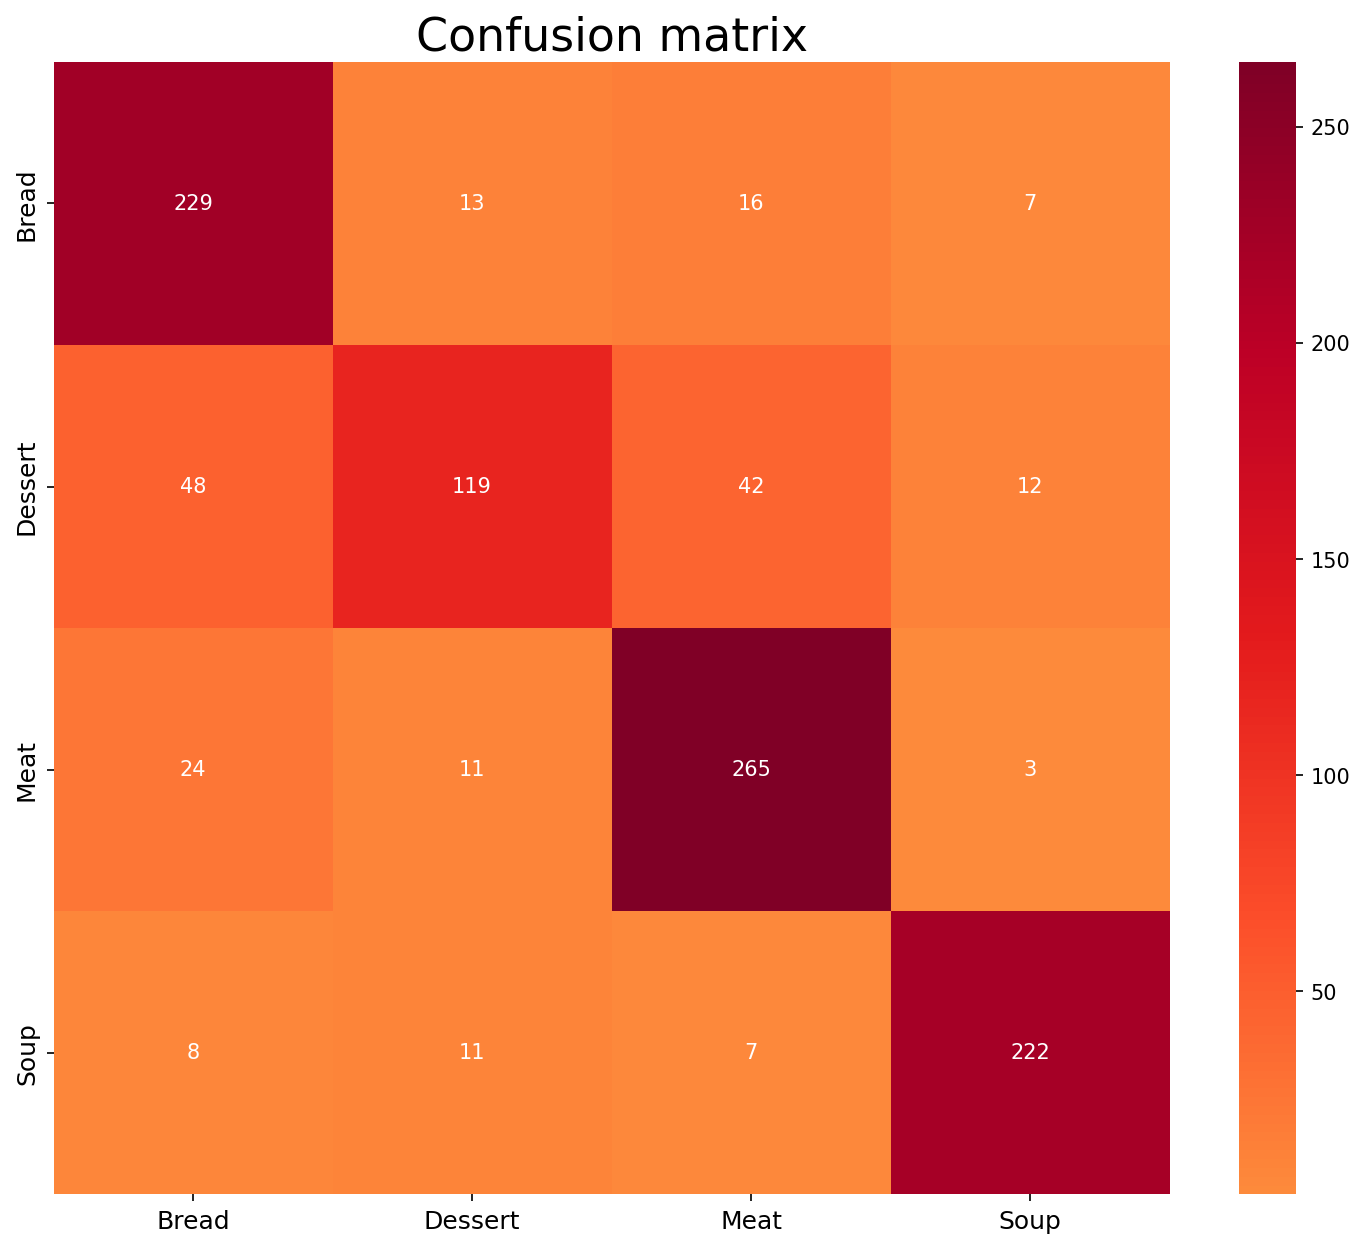

In [12]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(confusionMatrix, 
            xticklabels=[dataset.getName(i) for i in accuracyDict.keys()], 
            yticklabels=[dataset.getName(i) for i in accuracyDict.keys()], 
            cmap='YlOrRd', 
            center=0, annot=True, fmt="d")

plt.title('Confusion matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Мы получили среднюю точность равную 0.68, что весьма неплохо для данного датасета. Модель хуже распознает картинки, на которых изображены десерты из категории __Dessert__. 

При анализе изображений человеком было сложно иногда верно распознать картинки группы __Dessert__, так как некоторые из них очень похожи на __Meat__ или __Soup__.

Также мы заметили, что система иногда распознавала пиццу из категории __Bread__ как __Soup__, так как при виде сверху картинки с пиццей действительно очень напоминают суп.

## Проверка наилучшей модели по картинкам

Теперь, когда модель обучена, мы можем ее протестировать с помощью набора данных для проверки.

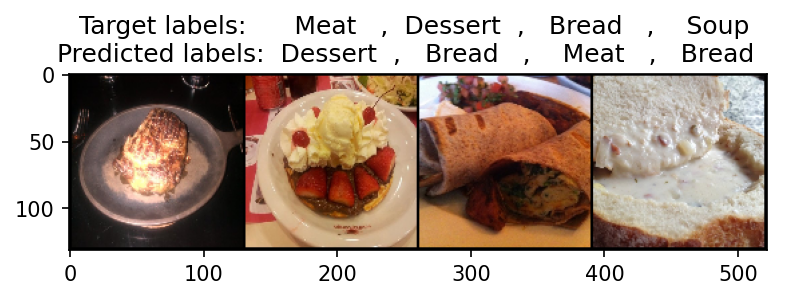

In [15]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

numImgs = 4
listImgs = []
listPredictLabels = []
listTargetLabels = []

for data in data_loader_val:
    features, labels = data
    
    labels = labels.to(device)
    features = dataset.getImgsTensors(features).to(device)

    outputs = best_model(features)
    outputs = torch.max(outputs, 1)[1].tolist()
    labels = labels.squeeze(1).tolist()
    
    if labels[0] != outputs[0]:
        numImgs -= 1
        
        listImgs.append(features.squeeze(0))
        listPredictLabels += labels
        listTargetLabels += outputs
        
    if numImgs == 0:
        break

plt.title('Target labels:'.center(20) + ', '.join([dataset.getName(i).center(10) for i in listPredictLabels]) + \
          '\nPredicted labels:'.center(20) + ', '.join([dataset.getName(i).center(10) for i in listTargetLabels]))
gridImgs = torchvision.utils.make_grid(listImgs).cpu()
plt.imshow(cv2.cvtColor(gridImgs.permute(1, 2, 0).numpy() / 255, cv2.COLOR_BGR2RGB))
plt.show()

По данным результатам можно сделать вывод:
* модель достаточно точно определяет класс картинки со средней точностью равной 0.68;
* модель хуже распознает картинки с изображенными на них десертами (точность распознавания меньше 0.5)
* так как некоторые картинки сложно распознать человеку, то и нейронная сеть с большей вероятностью отнесет некоторые картинки к другим классам. Это говорит о том, что нужно добавлять больше данных для train со сложными случаями распознавания.